In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import holidays

from pandas import CategoricalDtype
from bs4 import BeautifulSoup
from datetime import date
from prophet import Prophet
from prophet.serialize import model_to_json
from sklearn.model_selection import ParameterGrid
from scipy import stats
from tqdm import tqdm

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics



# Parcing data

In [2]:
# парсинг ключевой ставки в df
URL = 'https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=' + date.today().strftime('%d.%m.%Y')

data = requests.get(URL).text

bs4 = BeautifulSoup(data, "html.parser")
table = bs4.find_all("table")

df = pd.read_html(str(table))[0]
df.iloc[:,1:] /= 100

In [3]:
# преобразование столбца дата в формат datetime
df['Дата'] = pd.to_datetime(df['Дата'], dayfirst=True)

# перенаименование столбцов
df.columns = ['date', 'key_rate']

In [4]:
# общая информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2646 entries, 0 to 2645
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2646 non-null   datetime64[ns]
 1   key_rate  2646 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 41.5 KB


In [5]:
# основные описательные статистики для числовых признаков
df.iloc[:, 1:].describe()

,key_rate
count,2646.000000
mean,8.738379
std,3.201737
min,4.250000
25%,7.000000
50%,7.750000
75%,10.500000
max,20.000000


In [6]:
df[:5]

,date,key_rate
0,2024-04-19,16.0
1,2024-04-18,16.0
2,2024-04-17,16.0
3,2024-04-16,16.0
4,2024-04-15,16.0


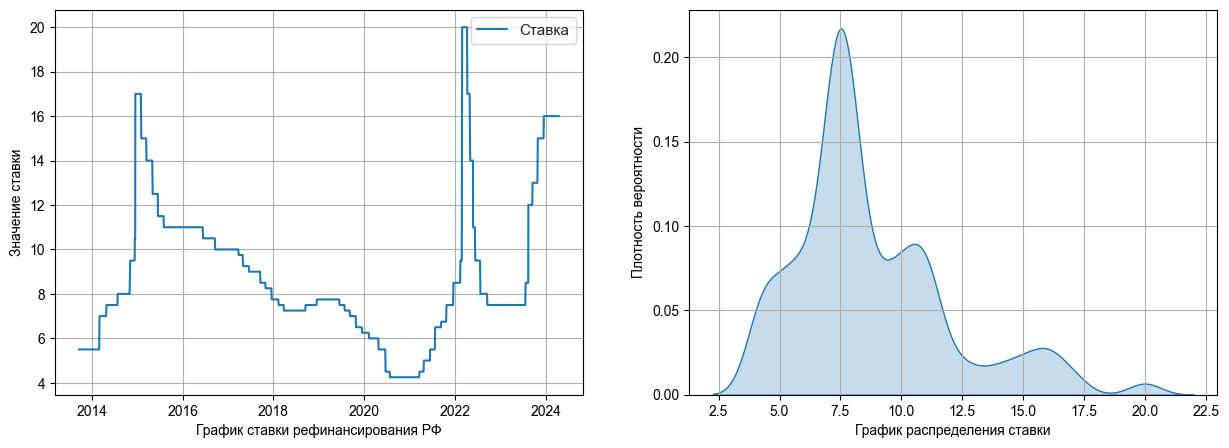

In [7]:
# рисуем график курса ключевой ствки ЦБ РФ и график распределения
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.set_theme(style="whitegrid", palette="Accent")

sns.lineplot(x='date', y='key_rate', data=df, label='Ставка', ax=axes[0])
axes[0].set_xlabel('График ставки рефинансирования РФ')
axes[0].set_ylabel('Значение ставки')
axes[0].legend(loc='best')
axes[0].grid(True)

sns.kdeplot(x=df['key_rate'], ax=axes[1], fill=True)
axes[1].grid(True)
axes[1].set_xlabel('График распределения ставки')
axes[1].set_ylabel('Плотность вероятности')
plt.show()

# EDA

In [8]:
# проверка на нормальное или ненормальное распределение.
test_shapiro = stats.shapiro(df['key_rate'])

print(test_shapiro)

if test_shapiro.pvalue < 0.05:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

ShapiroResult(statistic=0.9033581614494324, pvalue=5.171838383571118e-38)
Распределение не нормальное


In [9]:
def create_features(data, col_datetime):
    """Создание сезонов и дней недели"""

    data = data.copy()
    data['weekday'] = data[col_datetime].dt.day_name().astype(cat_day)
    data['month'] = data[col_datetime].dt.month_name().astype(cat_month)
    data['year'] = data[col_datetime].dt.year
    data['quarter'] = data['date'].dt.quarter
    data['date_offset'] = (data[col_datetime].dt.month * 100 + data.date.dt.day - 320) % 1300
    data['season'] = data[col_datetime].dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'})
    
    return data

cat_day = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered= True)
cat_month = CategoricalDtype(categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered= True)

df_features = create_features(data=df, col_datetime='date')

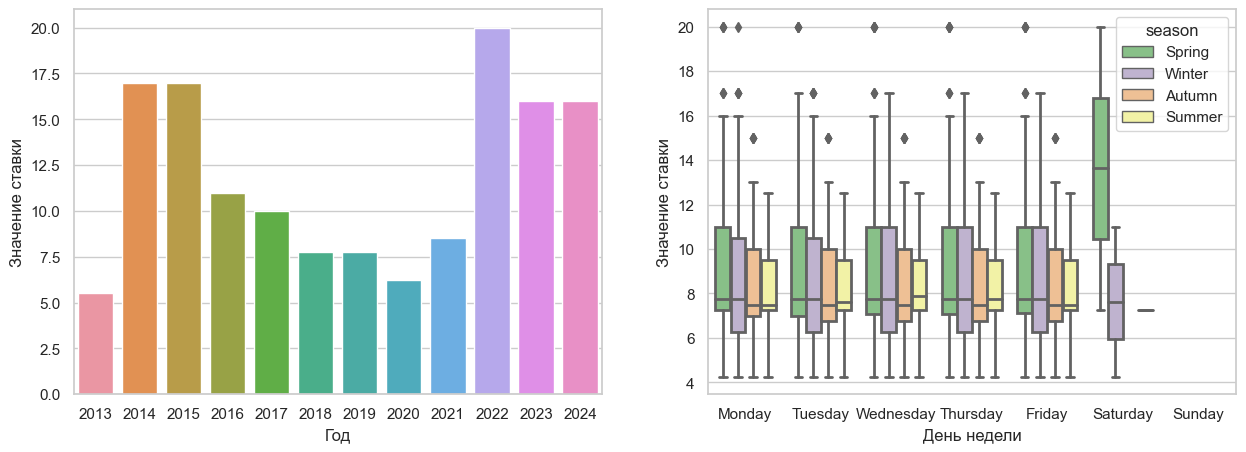

In [10]:
# рисуем графики для анализа
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

year_group = pd.DataFrame(df_features.groupby('year')['key_rate'].max()).reset_index().sort_values('key_rate')

sns.barplot(data=year_group, x='year', y='key_rate', ax=axes[0])
axes[0].set_xlabel('Год')
axes[0].set_ylabel('Значение ставки')

sns.boxplot(data=df_features, x='weekday', y='key_rate', hue='season', ax=axes[1], linewidth=2)
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Значение ставки')

plt.show()



In [11]:
# дропаем редкие субботние ключевые ставки
drop_trash = df_features[(df_features.weekday == 'Saturday')].index
df = df[~df.index.isin(drop_trash)]
df = df.reset_index(drop=True)

In [12]:
# перенаименование названия колонок для prophet
df.columns = ['ds', 'y']

# период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)


In [13]:
# сортируем данные по возрастанию для корректного отображения разделения графика
df = df.sort_values('ds')
df = df.reset_index(drop=True)

In [14]:
# разделение данных на train, test
df_train = df[:-pred_days]
df_test = df[-pred_days:]


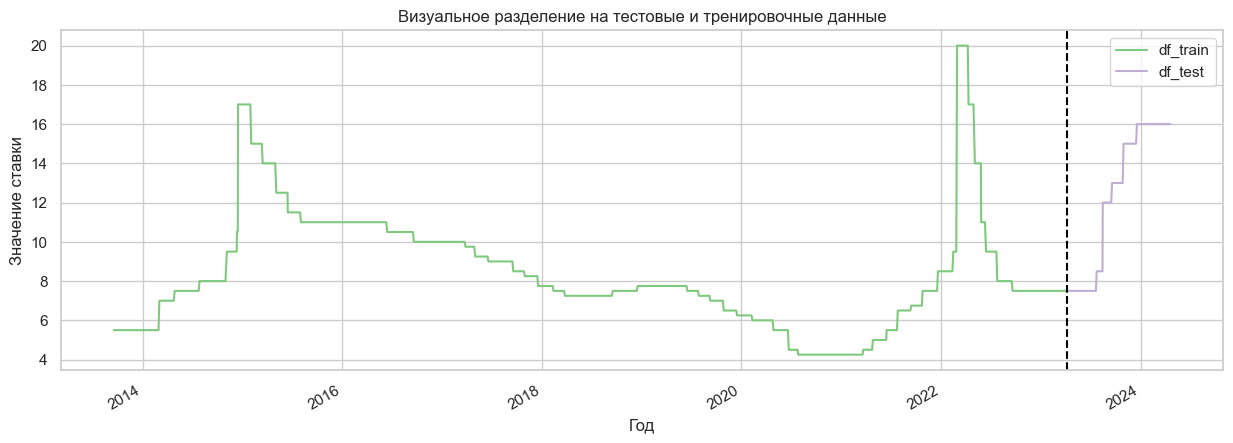

In [15]:
#отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

In [16]:
# обучение модели на train
model = Prophet()
model.fit(df_train)

02:00:16 - cmdstanpy - INFO - Chain [1] start processing
02:00:18 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
future = model.make_future_dataframe(periods=pred_days, freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2636,2023-12-22,11.932367,9.605773,14.206674
2637,2023-12-23,12.668622,10.079311,15.041255
2638,2023-12-24,12.680017,10.264282,14.941105
2639,2023-12-25,11.931565,9.522843,14.491585
2640,2023-12-26,11.940719,9.766515,14.314678


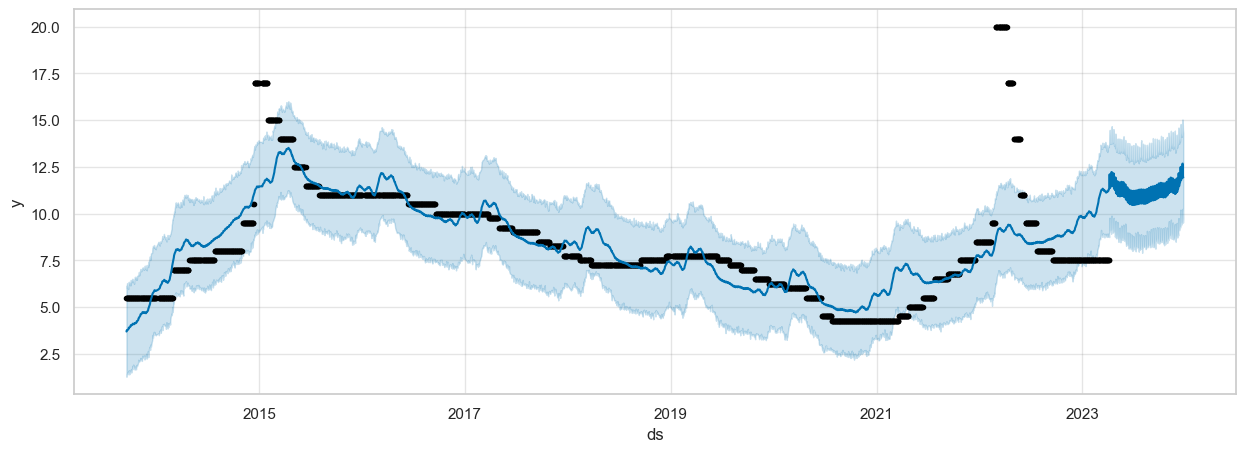

In [18]:
# смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

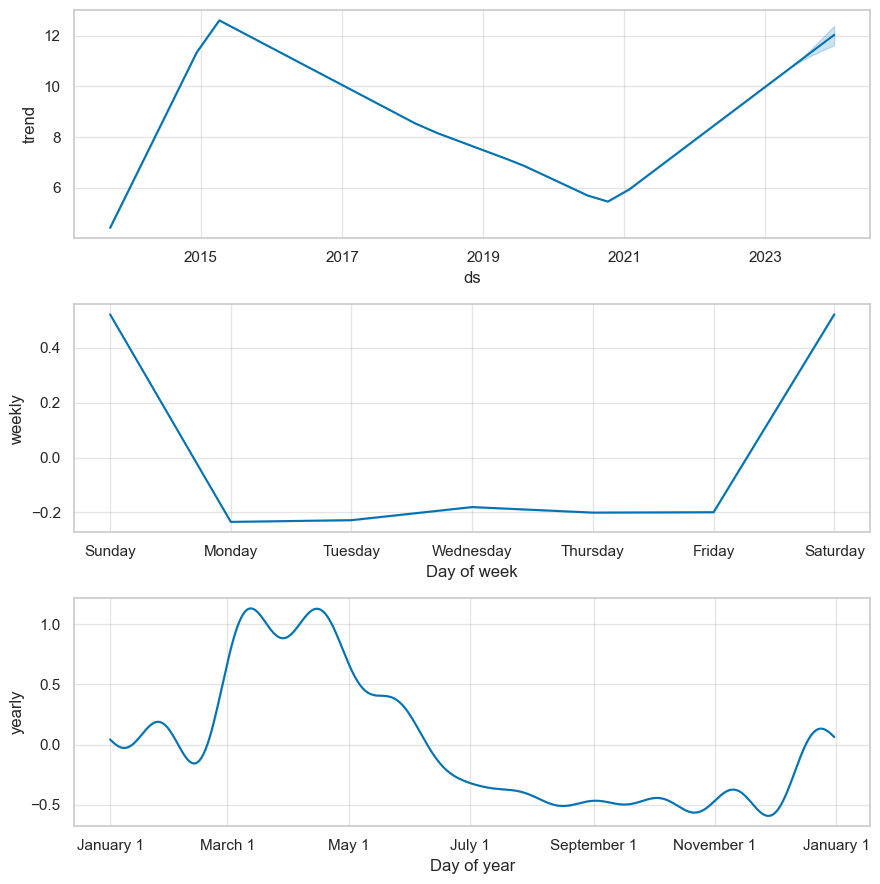

In [19]:
# смотрим тренд, годовые и сезонные признаки
fig = model.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [20]:
df_test_forecast = model.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
259,2024-04-15,13.569978,11.064135,16.056268
260,2024-04-16,13.578295,11.156166,16.126080
261,2024-04-17,13.623245,11.155026,15.900603
262,2024-04-18,13.595659,11.126941,16.100794
263,2024-04-19,13.585000,11.020730,16.139316


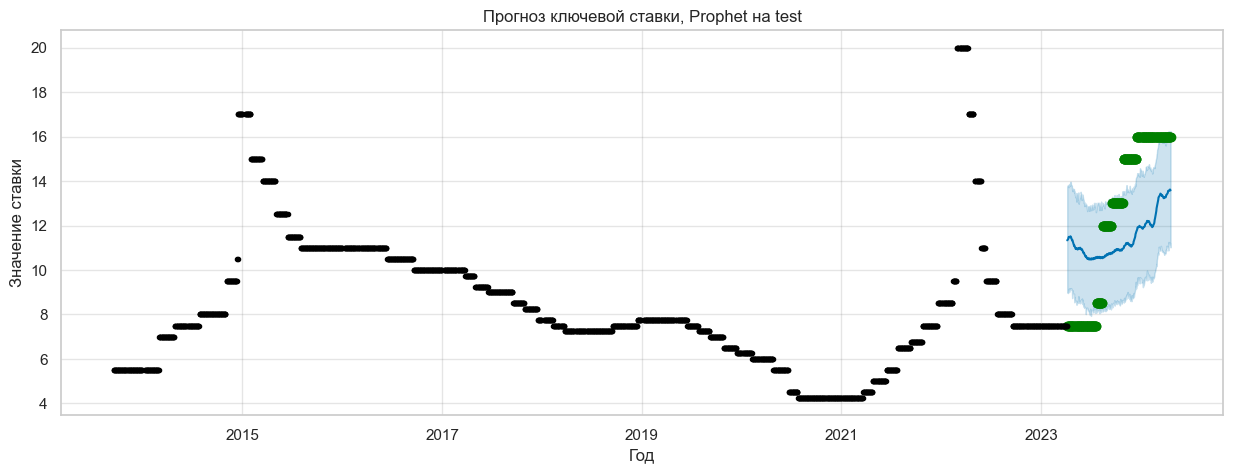

In [21]:
# смотрим совпадение фактического курса с предсказанным курсом prophet обученным на train, проверка модели
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model.predict(df_test)
fig = model.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet на test')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

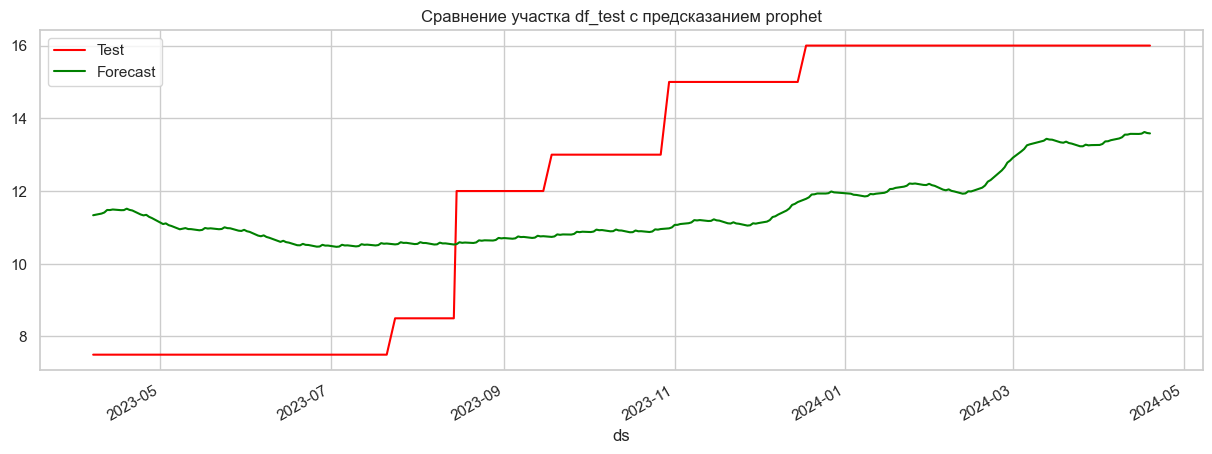

In [22]:
# сравнение участка df_test с предсказанием prophet
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet')
plt.show()

In [23]:
# просмотр метрик модели обученной на train в сравнени с прогнозом
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet,3.030006,0.270435,9.930713,3.151303


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, такие как праздники

In [24]:
# создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [25]:
# тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

02:00:26 - cmdstanpy - INFO - Chain [1] start processing
02:00:27 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2636,2023-12-22,11.987783,9.675614,14.410656
2637,2023-12-23,12.740203,10.436710,15.129371
2638,2023-12-24,12.761069,10.417292,15.042606
2639,2023-12-25,12.010598,9.567263,14.579872
2640,2023-12-26,12.029327,9.559004,14.306884


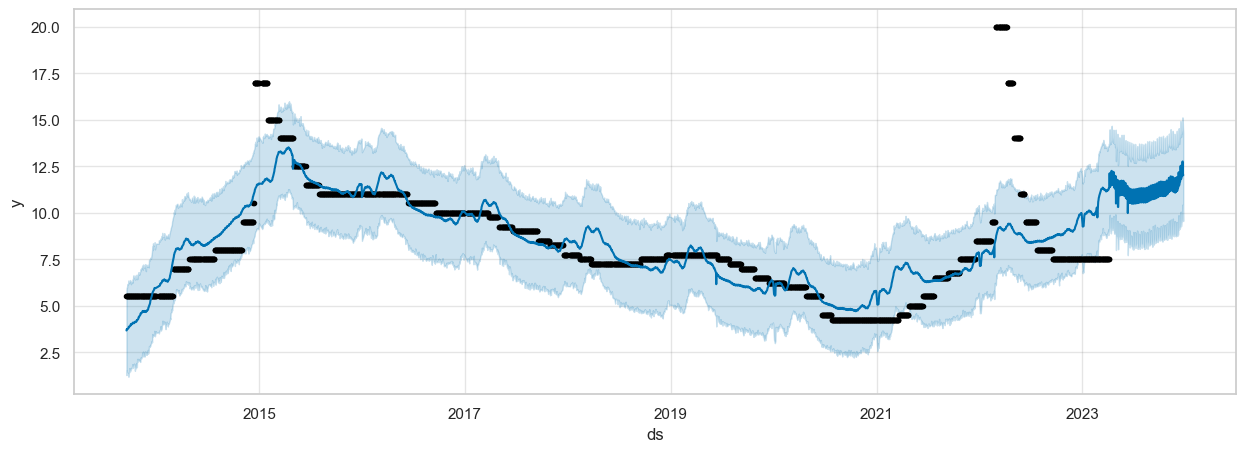

In [27]:
# смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

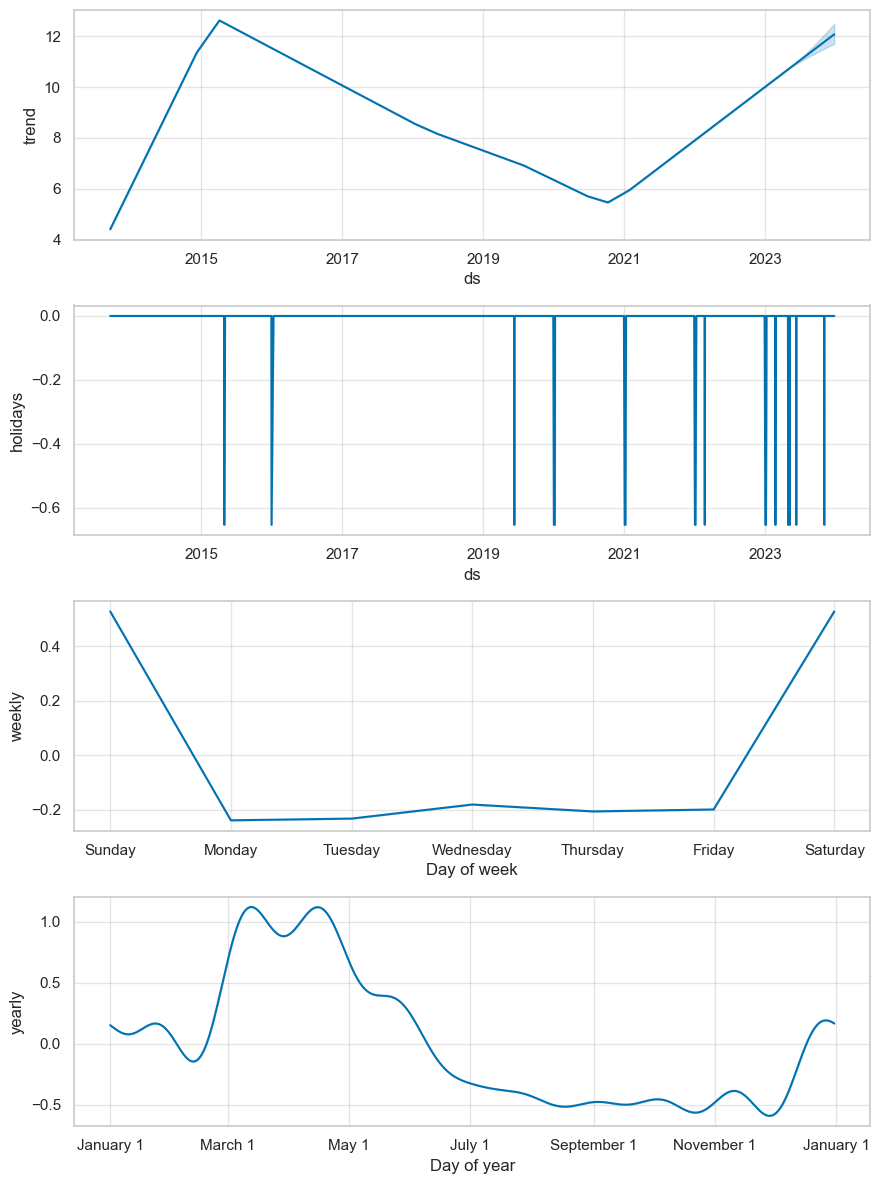

In [28]:
# смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

In [29]:
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
259,2024-04-15,13.593892,11.168286,16.122525
260,2024-04-16,13.603904,11.037047,16.070328
261,2024-04-17,13.654697,11.066040,16.106642
262,2024-04-18,13.623844,11.313329,16.004608
263,2024-04-19,13.620906,11.271141,16.089873


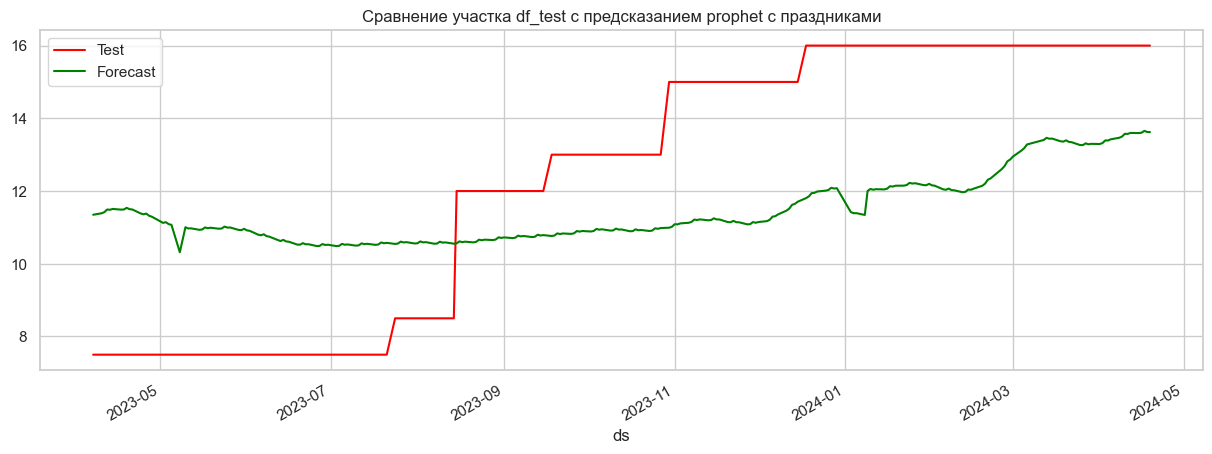

In [30]:
# сравнение участка df_test с предсказанием prophet
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [31]:
# сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet,3.030006,0.270435,9.930713,3.151303
0,Prophet_with_holidays,3.022853,0.270200,9.903127,3.146923


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [32]:
# создание сетки параметров и подсчёт количества вариаций обучения
params_grid = {
    'changepoint_prior_scale': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.3, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10], 
    'holidays_prior_scale': [0.01, 0.1, 1, 10],
    'seasonality_mode': ('multiplicative','additive')
}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt + 1

print('Количество моделей для обучения по сетке:', cnt)

Количество моделей для обучения по сетке: 672


In [33]:
"""Обучение тестовой модели по сетке параметров"""
# Создаем пустой DataFrame для сохранения метрик
model_grid_metrics = pd.DataFrame()
model_grid_parameters = pd.DataFrame(columns = ['Parameters'])

# Проходимся по сетке гиперпараметров
for p in tqdm(grid):
    #print(p)
#for p in grid:
#    print(p)
    
    # Создаем модель Prophet с текущими гиперпараметрами
    model_grid = Prophet(
        changepoint_prior_scale = p['changepoint_prior_scale'],
        seasonality_prior_scale = p['seasonality_prior_scale'],
        holidays_prior_scale = p['holidays_prior_scale'],
        seasonality_mode = p['seasonality_mode'],
        #changepoint_range = p['changepoint_range'],
        #daily_seasonality = p['daily_seasonality'],
        #weekly_seasonality = p['weekly_seasonality'],
        #yearly_seasonality = p['yearly_seasonality'],
        #holidays=holiday,
    )

    # Добавляем праздники в модель
    #model_grid.add_country_holidays(country_name='RU')

    # Обучаем модель данными
    model_grid.fit(df_train)

    # Создаем фрейм данных для предсказаний
    model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

    # Делаем предсказания
    model_grid_forecast = model_grid.predict(model_grid_future)

    # Вычисляем метрики и добавляем новую строку в df
    model_grid_metrics = pd.concat([model_grid_metrics, get_metrics(y_test=df_test['y'], y_pred=model_grid_forecast['yhat'], name='Prophet_with_grid ')])
    model_grid_parameters = pd.concat([model_grid_parameters, pd.DataFrame({'Parameters': [p]})], ignore_index=True)



  0%|          | 0/672 [00:00<?, ?it/s]02:00:36 - cmdstanpy - INFO - Chain [1] start processing
02:00:37 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/672 [00:01<12:58,  1.16s/it]02:00:37 - cmdstanpy - INFO - Chain [1] start processing
02:00:38 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/672 [00:01<10:49,  1.03it/s]02:00:38 - cmdstanpy - INFO - Chain [1] start processing
02:00:38 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/672 [00:02<10:11,  1.09it/s]02:00:39 - cmdstanpy - INFO - Chain [1] start processing
02:00:40 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 4/672 [00:03<10:50,  1.03it/s]02:00:40 - cmdstanpy - INFO - Chain [1] start processing
02:00:40 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 5/672 [00:04<10:13,  1.09it/s]02:00:41 - cmdstanpy - INFO - Chain [1] start processing
02:00:41 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 6/672 [00:05<09:59,  1.11it/s]0

In [34]:
# Сброс индексов для будущего объединения с df параметров сетки
model_grid_metrics = model_grid_metrics.reset_index(drop=True)

In [35]:
# Объединение DataFrame по столбцам
metrics_parameters_with_grid = pd.concat([model_grid_metrics, model_grid_parameters], axis=1)
metrics_parameters_with_grid

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,5.519206,0.379531,45.257668,6.727382,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
1,Prophet_with_grid,5.681524,0.394514,47.105852,6.863370,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
2,Prophet_with_grid,5.596071,0.388111,45.820302,6.769069,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
3,Prophet_with_grid,5.651425,0.392177,46.667382,6.831353,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
4,Prophet_with_grid,5.510278,0.379960,44.931422,6.703090,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
...,...,...,...,...,...,...
667,Prophet_with_grid,12.982044,1.078741,321.936450,17.942588,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
668,Prophet_with_grid,4.133952,0.330231,19.983368,4.470276,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
669,Prophet_with_grid,4.165671,0.334183,20.186429,4.492931,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
670,Prophet_with_grid,4.199493,0.334805,20.673949,4.546861,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [36]:
# Сортировка по метрике
metrics_parameters_with_grid = metrics_parameters_with_grid.sort_values(by=['MAE'])
metrics_parameters_with_grid = metrics_parameters_with_grid.reset_index(drop=True)
metrics_parameters_with_grid.head()

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,3.562049,0.312365,14.023655,3.744817,"{'changepoint_prior_scale': 0.06, 'holidays_pr..."
1,Prophet_with_grid,3.562049,0.312365,14.023655,3.744817,"{'changepoint_prior_scale': 0.06, 'holidays_pr..."
2,Prophet_with_grid,3.562049,0.312365,14.023655,3.744817,"{'changepoint_prior_scale': 0.06, 'holidays_pr..."
3,Prophet_with_grid,3.562049,0.312365,14.023655,3.744817,"{'changepoint_prior_scale': 0.06, 'holidays_pr..."
4,Prophet_with_grid,3.563666,0.312245,14.052871,3.748716,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."


In [37]:
# Подсвечивание минимальных значений метрик
styled_df = metrics_parameters_with_grid.style.highlight_min(subset=['MAE','MAPE_%','MSE','RMSE'], color='green')
styled_df



,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,3.562049,0.312365,14.023655,3.744817,"{'changepoint_prior_scale': 0.06, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}"
1,Prophet_with_grid,3.562049,0.312365,14.023655,3.744817,"{'changepoint_prior_scale': 0.06, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}"
2,Prophet_with_grid,3.562049,0.312365,14.023655,3.744817,"{'changepoint_prior_scale': 0.06, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}"
3,Prophet_with_grid,3.562049,0.312365,14.023655,3.744817,"{'changepoint_prior_scale': 0.06, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}"
4,Prophet_with_grid,3.563666,0.312245,14.052871,3.748716,"{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}"
5,Prophet_with_grid,3.563666,0.312245,14.052871,3.748716,"{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}"
6,Prophet_with_grid,3.563666,0.312245,14.052871,3.748716,"{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}"
7,Prophet_with_grid,3.563666,0.312245,14.052871,3.748716,"{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}"
8,Prophet_with_grid,3.572395,0.312805,14.093774,3.754168,"{'changepoint_prior_scale': 0.06, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}"
9,Prophet_with_grid,3.572395,0.312805,14.093774,3.754168,"{'changepoint_prior_scale': 0.06, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}"


## Лучшие параметры после обучения по сетке

In [38]:
# Сохранение в переменную лучших параметров после обучения по сетке
best_params = metrics_parameters_with_grid['Parameters'][0]

# Просмотр лучших параметров
best_params


{'changepoint_prior_scale': 0.06,
 'holidays_prior_scale': 0.01,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10}

In [39]:
# Обучение модели на лучших параметрах
final_test_model = Prophet(**best_params)
final_test_model.fit(df_train)

02:16:01 - cmdstanpy - INFO - Chain [1] start processing
02:16:02 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
# Вывод всех параметров модели Prophet
print(final_test_model.params)

OrderedDict([('lp__', array([[4392.98]])), ('k', array([[2.49033]])), ('m', array([[0.225095]])), ('delta', array([[ 1.87626e-09,  2.96387e-01,  4.04475e-08, -6.43995e-01,
        -2.88318e+00,  6.51303e-08, -3.22010e-08,  9.96039e-08,
         8.00336e-08, -1.62825e-08,  2.59100e-08,  4.14112e-08,
         1.48026e-08,  5.72631e-02,  3.40974e-01,  1.11477e-08,
         4.38787e-09, -5.43076e-04, -4.60102e-01, -2.86329e-08,
        -1.98271e-08,  3.08782e-01,  1.45843e+00,  5.14132e-02,
        -1.78994e-05]])), ('sigma_obs', array([[0.0911807]])), ('beta', array([[ 3.37460e-02,  1.98754e-03, -2.17597e-03, -1.13942e-02,
        -5.36907e-03,  4.32389e-03, -9.76256e-04,  5.21750e-03,
         8.49615e-04,  4.36732e-03,  1.98040e-03,  1.66720e-03,
         8.81216e-04,  1.14219e-03,  8.89381e-05, -2.89583e-03,
        -4.95188e-03, -2.60733e-03, -3.58108e-03,  3.57021e-04,
         1.34626e-02, -9.73246e-03, -1.20905e-02, -2.58459e-03,
         1.83222e-03,  3.31512e-03]])), ('trend', ar

In [41]:
# Прогнозировние после обучния на луших параметрах
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2636,2023-12-22,11.984639,9.465005,14.315419
2637,2023-12-23,12.649688,10.067899,15.077229
2638,2023-12-24,12.661169,10.272511,15.168400
2639,2023-12-25,11.985012,9.709571,14.370986
2640,2023-12-26,11.993619,9.424166,14.434616


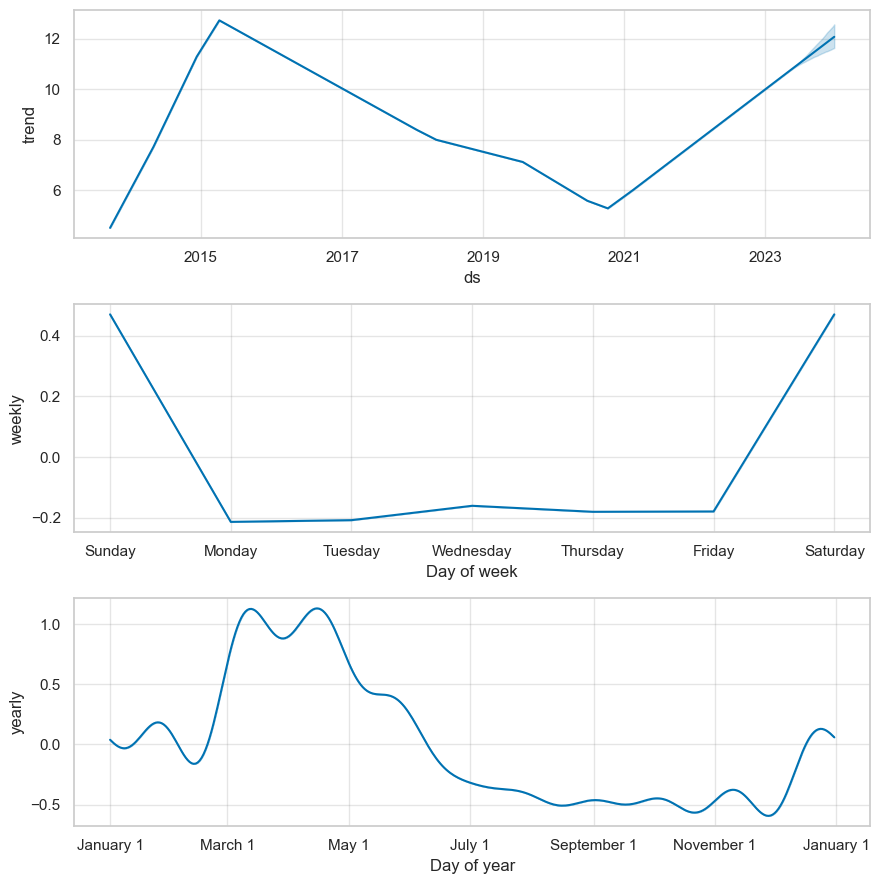

In [42]:
# Просмотр компонентов
fig = final_test_model.plot_components(forecast)

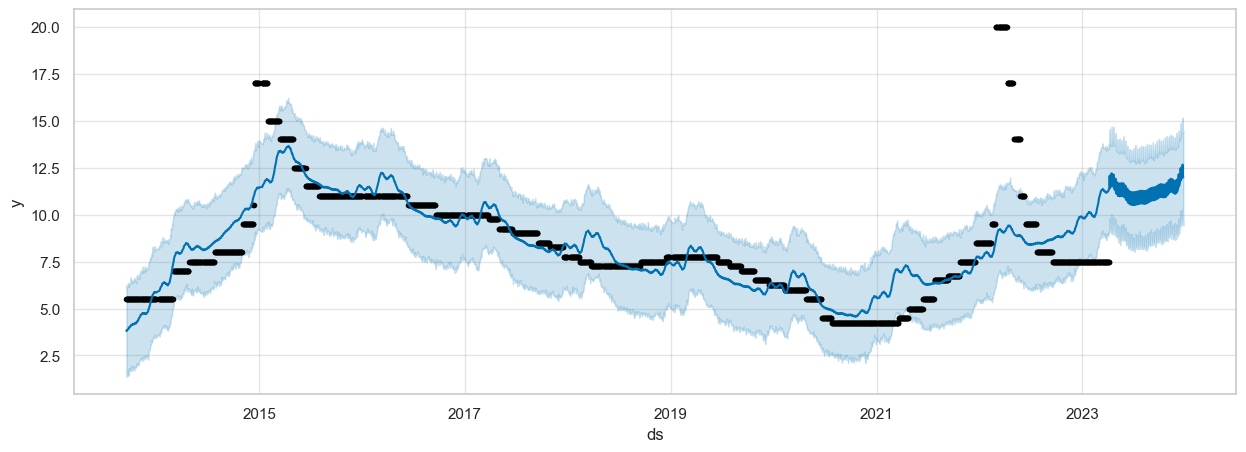

In [43]:
# Смотрим график прогноза и фактического df_dest после обучния на лучших параметрах
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

In [44]:
# Просмотр df данных после предсказания на лучших параметрах
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
259,2024-04-15,13.638715,11.037762,16.154782
260,2024-04-16,13.646795,11.055763,16.173921
261,2024-04-17,13.691766,11.381173,16.243592
262,2024-04-18,13.664940,11.082913,16.173247
263,2024-04-19,13.654374,10.972886,16.267866


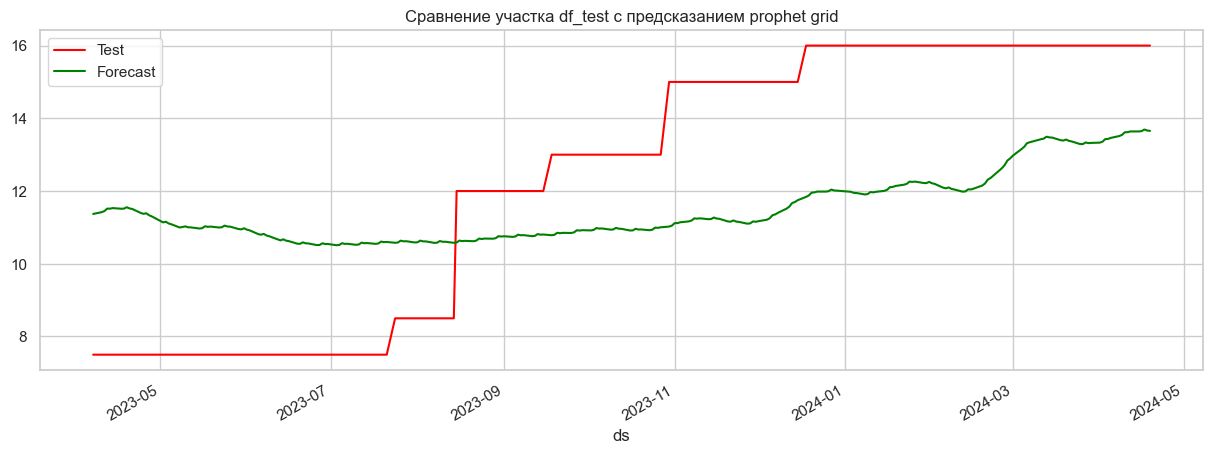

In [45]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [46]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_with_grid')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet,3.030006,0.270435,9.930713,3.151303
0,Prophet_with_holidays,3.022853,0.270200,9.903127,3.146923
0,Prophet_with_grid,3.009669,0.269961,9.815191,3.132921


In [47]:
# Сохранение DataFrame df в файл data/df.csv
df.to_csv('../data/df.csv', index=False)

# Сохранение DataFrame df_train в файл data/df_train.csv
df_train.to_csv('../data/df_train.csv', index=False)

# Сохранение DataFrame df_test в файл data/df_test.csv
df_test.to_csv('../data/df_test.csv', index=False)


In [48]:
# Сохранение модели в JSON файл
with open('../backend/final_test_model.json', 'w') as fout:
    fout.write(model_to_json(final_test_model))